$\def \dot #1#2{\left\langle #1, #2 \right\rangle}$
$\def \adot #1#2{\left\langle #1, #2 \right\rangle}$
$\def \cD {\mathcal{D}}$
$\def \cM {\mathcal{M}}$
$\def \bc {\mathbf{c}}$
$\def \bv {\mathbf{v}}$
$\def \bG {\mathbf{G}}$

# Testing localised reduced bases

In this test we are soving the usual PDE

$$
- \nabla \cdot (a(y) \nabla u) = f
$$

where the parameterised field is given by $a(y) = \bar a + c \sum_{i=1}^{16} y_i D_i$, where the $D_i$ are dyadic subdivisions, of size $1/4 \times 1/4$. We have $y\in Y := [-1,1]^{16}$ and $c < \bar a$ such that $a(y)$ is always bounded above 0.

We look at a few strategies for subdividing $Y$ and looking at local reduced bases on the subdivision. For example if we subdivide in the $y_1$ direction for example and consider $C_1 = [-1,0] \times [-1,1]^{15}$ and $C_2 = [0,1] \times [-1,1]^{15}$, then split the training set depending on which cell $y$ originated from. Then we make a reduced basis in the usual greedy way, for the training set on each cell.

Below there will be various pre-determined splits on various coordinate directions, shown in the plots below. Keep in mind these are full splits, that is if we split the domain in coordinate $i$ and then $j$, there will be 4 resulting cells, as the $j$ split will split both the already created cells from the $i$th split.

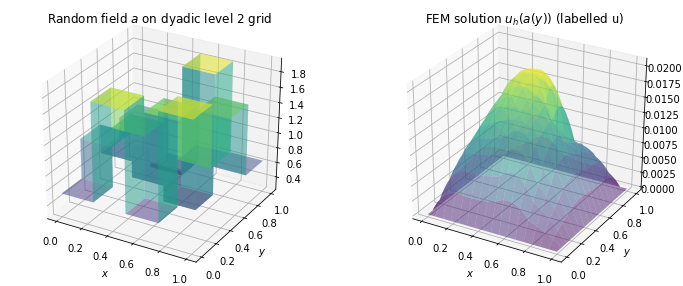

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.append("../../")
import pyhilbert as hil
import pyredmod as rm

%matplotlib inline

def make_soln(points, field_space, fem_space, a_bar=1.0, c=0.5, f=1.0, verbose=False):
    
    solns = hil.Basis(np.zeros((H1_fine.n, len(points))), space=H1_fine)
    fields = []
    
    for i, p in enumerate(points):
        field = hil.Vector(a_bar + c * p, space=field_space)
        fields.append(field)
        # Then the fem solver (there a faster way to do this all at once? This will be huge...
        fem_solver = hil.DyadicFEMSolver(fem_space = fem_space, rand_field = field, f = 1)
        fem_solver.solve()
        solns._values[:,i] = fem_solver.u.values
        
    return solns, fields

fem_div = 7
H1_fine = hil.H1DyadicSq(fem_div)
field_div = 2
L2_coarse = hil.L2DyadicSq(field_div)
a_bar = 0.1
c = 2.0
side_n = 2**field_div

def diffusion_pde(points):
    solns, fields = make_soln(points, field_space=L2_coarse, fem_space=H1_fine, a_bar=a_bar, c=c)
    return solns

np.random.seed(5)
u, a = make_soln(np.random.random((1,side_n * side_n)), field_space=L2_coarse, fem_space=H1_fine, a_bar=a_bar, c=c)
u = u[0]; a = a[0]
                           
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
a.plot(ax, title='Random field $a$ on dyadic level 2 grid')
ax = fig.add_subplot(1, 2, 2, projection='3d')
u.plot(ax, title='FEM solution $u_h(a(y))$ (labelled $\mathtt{u}$)')
plt.show()

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [ ]:
N_tr = 2000
N_te = 100

d = side_n * side_n

y_range = np.zeros((d,2))
y_range[:,1] = 1

np.random.seed(1)
points_tr = np.random.random((N_tr, d)) * (y_range[:, 1] - y_range[:, 0]) + y_range[:, 0]
us_tr = diffusion_pde(points_tr)
points_te = np.random.random((N_te, d)) * (y_range[:, 1] - y_range[:, 0]) + y_range[:, 0]
us_te = diffusion_pde(points_te)

U_tr = rm.ParamBasis(us_tr, points_tr)

lwc = rm.ParamDecompTreeWC(U_tr, diffusion_pde, y_range, est_n=64, min_N=500)
lwc.split_leaf(directions=(5,6,9,10))
print(anytree.RenderTree(lwc).by_attr())

In [14]:
# local_width is the width of the measurement squares in terms of FEM mesh squares
width_div = 1
local_width = 2**width_div
spacing_div = 4

Wm_reg, Wloc_reg = rm.make_local_avg_grid_basis(width_div, spacing_div, fem_div, return_map=True)
Wm = Wm_reg.orthonormalise()

m = Wm.n
print(f'm={m}')
    
w_te = Wm.A @ us_te

m=64


In [7]:
stats = np.zeros([2, N_te, len(range(2,m,2))])

pw_est = lwc.oracle_estimator
lin_est = lwc.lin_est
pw_est.Wm = Wm
lin_est.Wm = Wm

for i, n in enumerate(range(2,m,2)):
    #print(f'n = {n}')
    trunc_pw_est = pw_est.truncate(slice(0,n))
    trunc_lin_est = lin_est[:n]
    for k, u in enumerate(us_te):
        u_star = trunc_lin_est.best_estimate(w_te[:,k])
        stats[0, k, i] = (u - u_star).norm()
        u_star = trunc_pw_est.best_estimate(w_te[:,k], points_te[k])
        stats[1, k, i] = (u - u_star).norm()

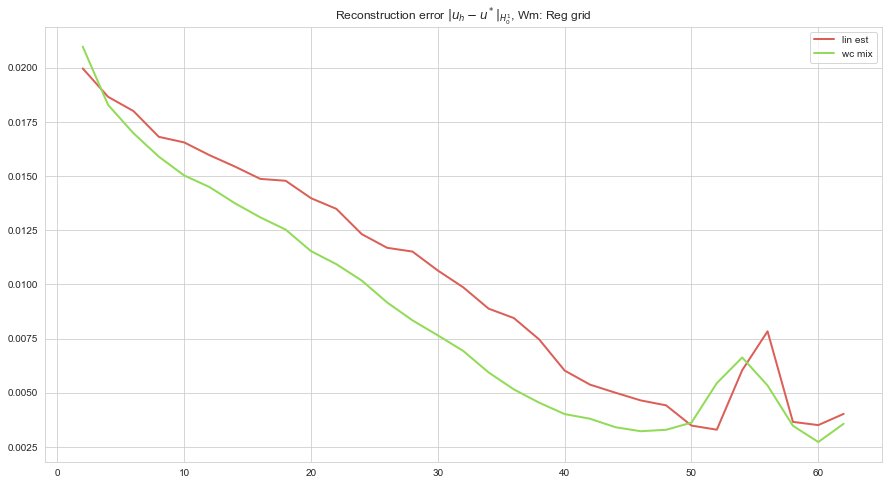

In [15]:
sns.set_palette('hls', 4)
cp = sns.color_palette()
sns.set_style('whitegrid')
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(1, 1, 1, title='Reconstruction error $\| u_h - u^* \|_{H_0^1}$, Wm: Reg grid')

plt.plot(range(2, m, 2), stats[0, :, :].mean(axis=0), label=f'lin est', lw=2, color=cp[0])
plt.plot(range(2, m, 2), stats[1, :, :].mean(axis=0), label=f'wc mix', lw=2, color=cp[1])
#for k, u in enumerate(us_te):
#    plt.semilogy(range(2, 2*m, 2), stats[0, k, :], ':', lw=1, color=cp[0])  
#    plt.semilogy(range(2, 2*m, 2), stats[1, k, :], ':', lw=1, color=cp[1]) 
    
plt.legend(loc=1)
plt.show()

In [ ]:
lwc_corners = rm.ParamDecompTreeWC(U_tr, diffusion_pde, y_range, est_n=64, min_N=100)
lwc_corners.split_leaf(directions=(0,3,12,15))
print(anytree.RenderTree(lwc).by_attr())

stats_corners = np.zeros([2, N_te, len(range(2,m,2))])

pw_est = lwc_corners.oracle_estimator
lin_est = lwc_corners.lin_est
pw_est.Wm = Wm
lin_est.Wm = Wm

for i, n in enumerate(range(2,m,2)):
    #print(f'n = {n}')
    trunc_pw_est = pw_est.truncate(slice(0,n))
    trunc_lin_est = lin_est[:n]
    for k, u in enumerate(us_te):
        u_star = trunc_lin_est.best_estimate(w_te[:,k])
        stats_corners[0, k, i] = (u - u_star).norm()
        u_star = trunc_pw_est.best_estimate(w_te[:,k], points_te[k])
        stats_corners[1, k, i] = (u - u_star).norm()

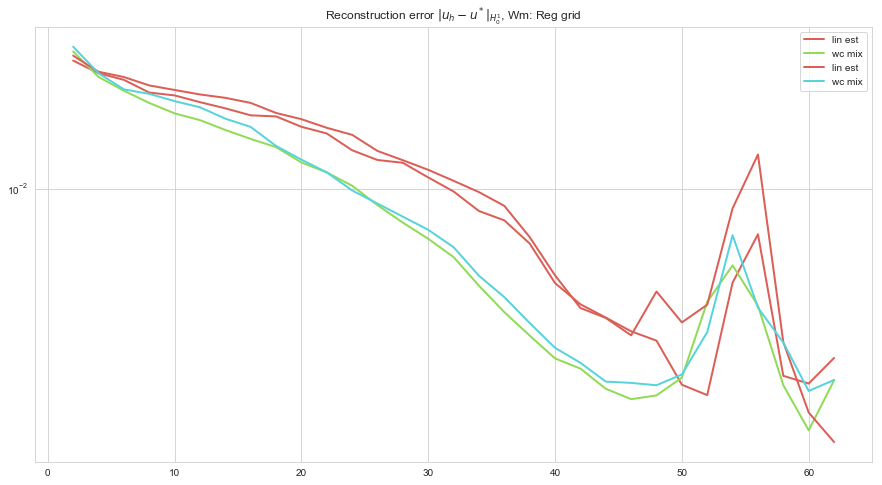

In [21]:
sns.set_palette('hls', 4)
cp = sns.color_palette()
sns.set_style('whitegrid')
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(1, 1, 1, title='Reconstruction error $\| u_h - u^* \|_{H_0^1}$, Wm: Reg grid')

plt.semilogy(range(2, m, 2), stats[0, :, :].mean(axis=0), label=f'lin est', lw=2, color=cp[0])
plt.semilogy(range(2, m, 2), stats[1, :, :].mean(axis=0), label=f'wc mix', lw=2, color=cp[1])
plt.semilogy(range(2, m, 2), stats_corners[0, :, :].mean(axis=0), label=f'lin est', lw=2, color=cp[0])
plt.semilogy(range(2, m, 2), stats_corners[1, :, :].mean(axis=0), label=f'wc mix', lw=2, color=cp[2])
#for k, u in enumerate(us_te):
#    plt.semilogy(range(2, 2*m, 2), stats[0, k, :], ':', lw=1, color=cp[0])  
#    plt.semilogy(range(2, 2*m, 2), stats[1, k, :], ':', lw=1, color=cp[1]) 
    
plt.legend(loc=1)
plt.show()

In [ ]:
lwc_all = rm.ParamDecompTreeWC(U_tr, diffusion_pde, y_range, est_n=64, min_N=500)
lwc_all.split_leaf()

stats_all = np.zeros([2, N_te, len(range(2,m,2))])

pw_est = lwc_all.oracle_estimator
lin_est = lwc_all.lin_est
pw_est.Wm = Wm
lin_est.Wm = Wm

for i, n in enumerate(range(2,m,2)):
    trunc_pw_est = pw_est.truncate(slice(0,n))
    trunc_lin_est = lin_est[:n]
    for k, u in enumerate(us_te):
        u_star = trunc_lin_est.best_estimate(w_te[:,k])
        stats_all[0, k, i] = (u - u_star).norm()
        u_star = trunc_pw_est.best_estimate(w_te[:,k], points_te[k])
        stats_all[1, k, i] = (u - u_star).norm()

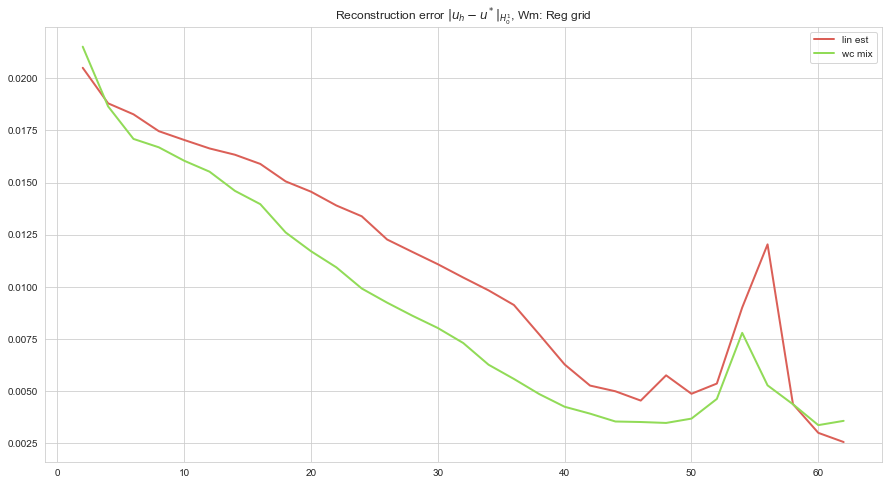

In [17]:
sns.set_palette('hls', 4)
cp = sns.color_palette()
sns.set_style('whitegrid')
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(1, 1, 1, title='Reconstruction error $\| u_h - u^* \|_{H_0^1}$, Wm: Reg grid')

plt.plot(range(2, m, 2), stats_all[0, :, :].mean(axis=0), label=f'lin est', lw=2, color=cp[0])
plt.plot(range(2, m, 2), stats_all[1, :, :].mean(axis=0), label=f'wc mix', lw=2, color=cp[1])
#for k, u in enumerate(us_te):
#    plt.semilogy(range(2, 2*m, 2), stats[0, k, :], ':', lw=1, color=cp[0])  
#    plt.semilogy(range(2, 2*m, 2), stats[1, k, :], ':', lw=1, color=cp[1]) 
    
plt.legend(loc=1)
plt.show()

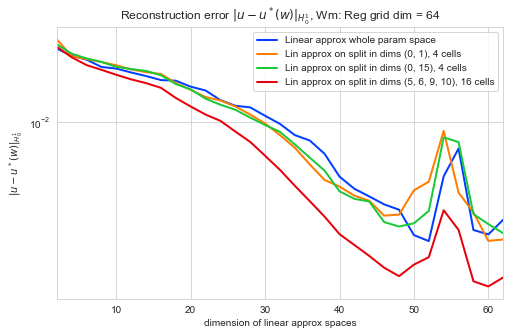

In [82]:
splits_single = tuple((i,) for i in range(8))
splits_two = ((0,1), (6,7), (0,15), (5,10))
splits_four = ((0,1,2,3), (5,6,9,10), (0,3,12,15))
splits = splits_single + splits_two + splits_four


files_single = [f'recon_error_64_{split}.npy' for split in splits_single]
files_more = [f'recon_error_64_{split}.npy' for split in splits_two + splits_four]

split_choice = ((0,1), (0,15), (5,6,9,10))
files_more = [f'recon_error_64_{split}.npy' for split in split_choice]

sns.set_palette('bright', 4)

sns.set_style('whitegrid')
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1, title='Reconstruction error $\| u - u^*(w) \|_{H_0^1}$, Wm: Reg grid dim = 64')

plt.semilogy(range(2, m, 2), stats[0].mean(axis=0), label='Linear approx whole param space', lw=2)
for split, file in zip(split_choice, files_more):
    try:
        stat = np.load('./scripts/results/' + file)
        plt.semilogy(range(2, m, 2), stat.mean(axis=0), label=f'Lin approx on split in dims {split}, {2**len(split)} cells', lw=2)
    except:
        print(f'File {file} doesn\'t exist')
plt.xlim([2.0,62.0])
plt.xlabel('dimension of linear approx spaces')    
plt.ylabel(r'$\| u - u^*(w) \|_{H_0^1}$')
plt.legend(loc=1)
plt.savefig('pw_lin_oracle_err')
plt.show()

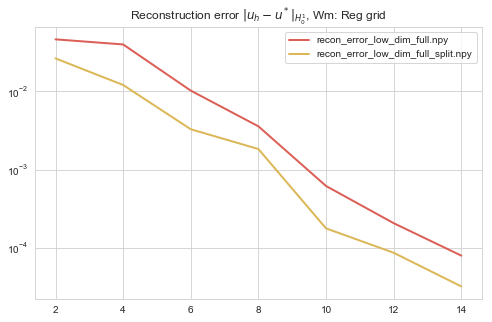

In [3]:
sns.set_palette('hls', 9)

sns.set_style('whitegrid')
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1, title='Reconstruction error $\| u_h - u^* \|_{H_0^1}$, Wm: Reg grid')

for file in ['recon_error_low_dim_full.npy', 'recon_error_low_dim_full_split.npy']:
    try:
        stat = np.load('./scripts/results/' + file)
        plt.semilogy(range(2, 16, 2), stat.mean(axis=0), label=file, lw=2)
    except:
        print(f'no file {file}')
    
plt.legend(loc=1)
plt.show()